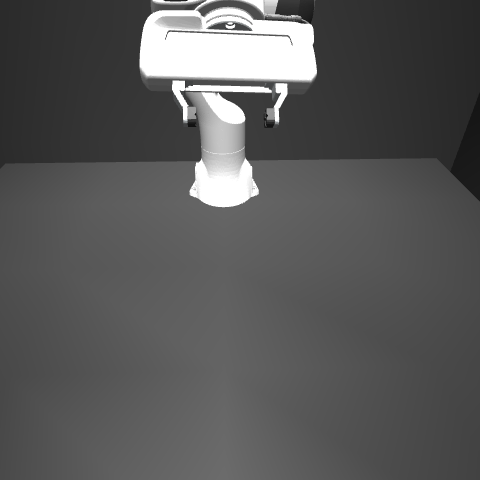

In [1]:
%load_ext autoreload
%autoreload 2

from utils.robot_env import RobotEnv

from utils.pointclouds import read_calibration_file
calib_file = "/home/memmelma/Projects/robotic/most_recent_calib.json"
calib_dict = read_calibration_file(calib_file)
robot_config = {
    "model_path": "/home/memmelma/Projects/robotic/franka_emika_panda/scene.xml",
    "camera_name": "custom",
    "img_render": [480, 480],
    "img_resize": [128, 128],
    "calib_dict": calib_dict,
    "n_steps": 50,
    "time_steps": 0.002,
    "reset_qpos_noise_std": 1e-2,
}
env = RobotEnv(**robot_config)
env.reset()

from PIL import Image
Image.fromarray(env.render())

In [2]:
%load_ext autoreload
%autoreload 2
from utils.mp import CuroboWrapper
mp = CuroboWrapper(fk_solver=True, ik_solver=True, mp_solver=False, interpolation_dt=env.n_steps * env.time_steps)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch

qpos = env.get_qpos()
pos = env.get_ee_pos()

pos_mp, quat_mp = mp.compute_fk(torch.from_numpy(qpos).float().cuda()[None])

qpos_mp = mp.compute_ik(pos_mp, quat_mp)

In [4]:
import numpy as np

def get_pose(qpos):
    pos, quat = mp.compute_fk(torch.from_numpy(qpos).float().cuda()[None])
    return np.concatenate((pos.cpu().numpy()[0], quat.cpu().numpy()[0]), axis=0)

def get_qpos(pose):
    qpos = mp.compute_ik(torch.from_numpy(pose[:3]).float().cuda()[None], torch.from_numpy(pose[3:]).float().cuda()[None])
    return qpos.cpu().numpy()[0]

In [5]:
def step(env, qpos):
    env.step(np.concatenate((qpos, [1.0])))
    return env.get_qpos()

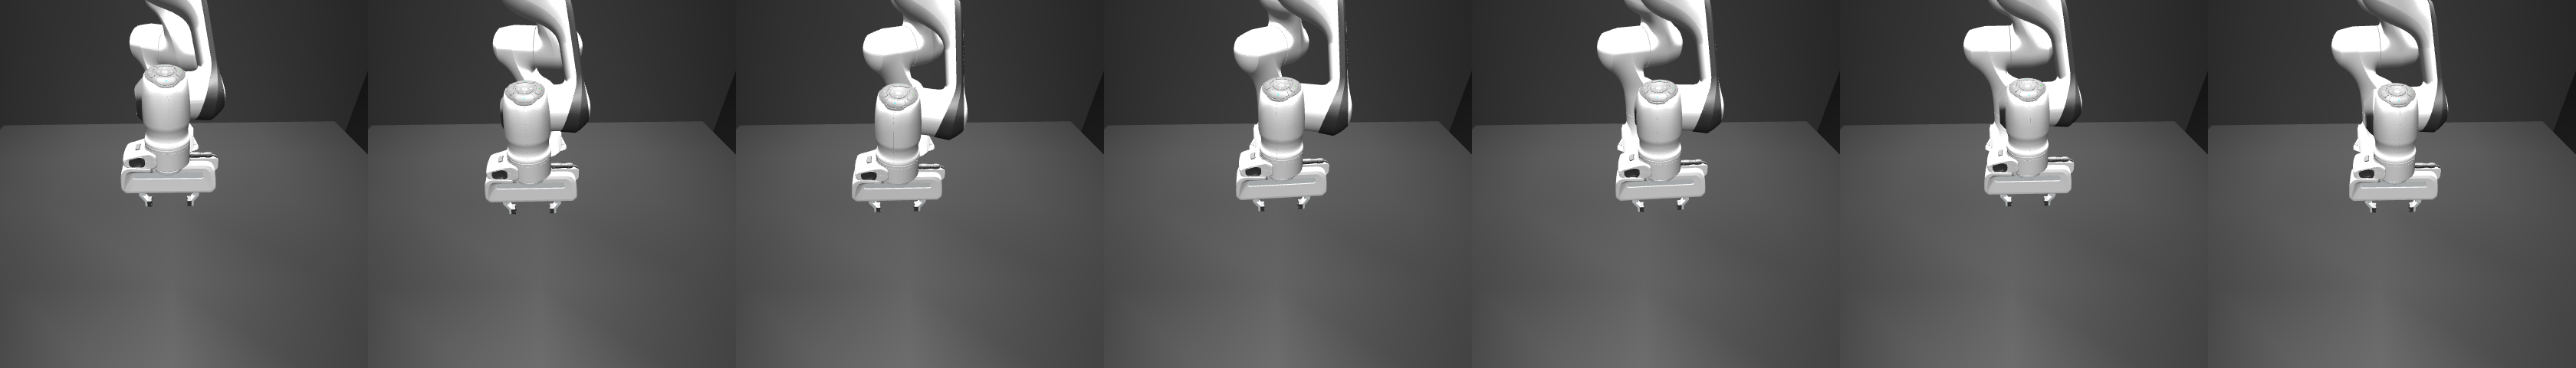

In [6]:
quat = [0, 1, 0, 0]
env.reset_qpos = get_qpos(np.array([0.4, 0.0, 0.2, 0, 1, 0, 0]))
env.reset()

imgs = []
qpos = env.get_qpos()
pose = get_pose(qpos)
imgs.append(env.render())

actions = np.array([
    [0,0,-0.1],
    [0,0,0.1],
    [0,-0.1,0],
    [0,0.1,0],
    [-0.1,0,0],
    [0.1,0,0],
])
poses = []
poses.append(pose)

for act in actions:

    pose[:3] += act / 3
    pose[3:] = quat
    new_qpos = get_qpos(pose)
    
    qpos = step(env, new_qpos)
    pose = get_pose(qpos)
    poses.append(pose)

    imgs.append(env.render())

# pose = get_pose(qpos)
# qpos_mp = get_qpos(pose)
# qpos_mp, qpos

from PIL import Image
Image.fromarray(np.concatenate(imgs, axis=1))

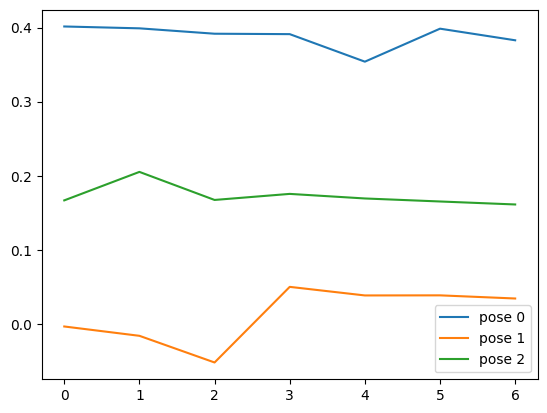

In [7]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.plot(np.array(poses)[:, i], label=f"pose {i}")
plt.legend()
plt.show()


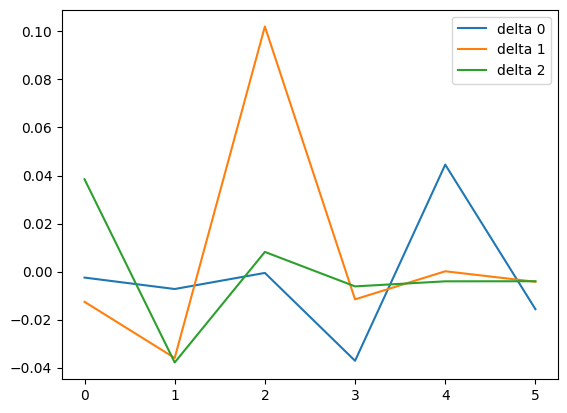

In [8]:
# plot deltas poses
import matplotlib.pyplot as plt

deltas = np.diff(poses, axis=0)[..., :3]
for i in range(deltas.shape[1]):
    plt.plot(deltas[:, i], label=f"delta {i}")
plt.legend()
plt.show()


In [ ]:
import mujoco

env.reset()

ee_pose_init = get_pose(qpos)
q_init = env.get_qpos()
target_pos, target_quat = ee_pose_init[:3], ee_pose_init[3:]
target_pos[1] += 0.1

def mujoco_ik(env, target_pos, target_quat):
    
    data = env.data
    model = env.model
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "ee_site")


    integration_dt: float = 0.1 # 1.0
    damping: float = 1e-4

    # Pre-allocate numpy arrays.
    jac = np.zeros((6, model.nv))
    diag = damping * np.eye(6)
    error = np.zeros(6)
    error_pos = error[:3]
    error_ori = error[3:]
    site_quat = np.zeros(4)
    site_quat_conj = np.zeros(4)
    error_quat = np.zeros(4)

    # Position error.
    error_pos[:] = target_pos - data.site(site_id).xpos

    # Orientation error.
    mujoco.mju_mat2Quat(site_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(site_quat_conj, site_quat)
    mujoco.mju_mulQuat(error_quat, target_quat, site_quat_conj)
    mujoco.mju_quat2Vel(error_ori, error_quat, 1.0)

    # Get the Jacobian with respect to the end-effector site.
    mujoco.mj_jacSite(model, data, jac[:3], jac[3:], site_id)

    # Solve system of equations: J @ dq = error.
    dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)

    # Integrate joint velocities to obtain joint positions.
    q = data.qpos.copy()
    mujoco.mj_integratePos(model, q, dq, integration_dt)

    # Set the control signal.
    # np.clip(q, *model.jnt_range.T, out=q)
    return q

# env.step(q)
# ee_pose_final = get_pose(env.get_qpos())

# np.around(ee_pose_init - ee_pose_final, 2)

NameError: name 'q' is not defined

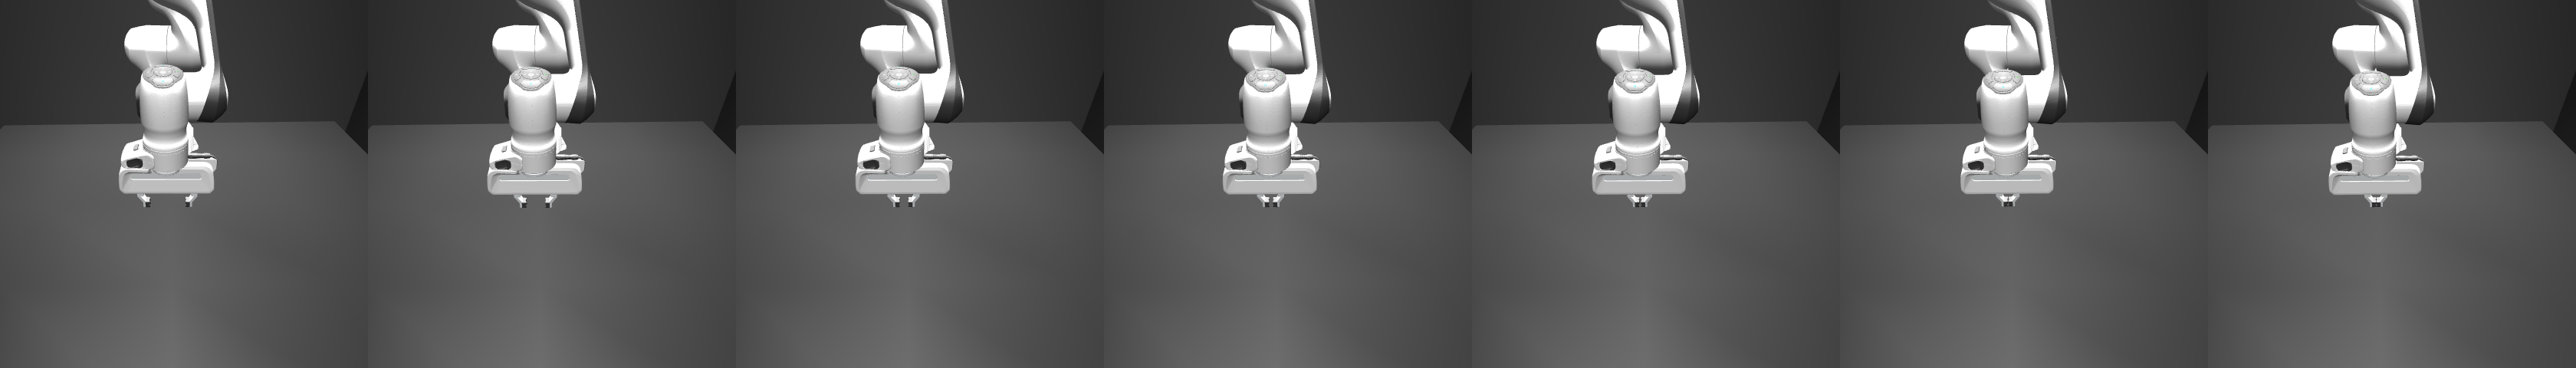

In [10]:
quat = [0, 1, 0, 0]
env.reset_qpos = get_qpos(np.array([0.4, 0.0, 0.2, 0, 1, 0, 0]))
env.reset()

imgs = []
pose = np.concatenate((env.get_ee_pos(), env.get_ee_quat()))
imgs.append(env.render())

actions = np.array([
    [0,0,-0.1],
    [0,0,0.1],
    [0,-0.1,0],
    [0,0.1,0],
    [-0.1,0,0],
    [0.1,0,0],
])
poses_mj = []
poses_mj.append(pose)

for act in actions:

    pose[:3] += act / 3
    pose[3:] = quat
    new_qpos = mujoco_ik(env, pose[:3], pose[3:])
    
    qpos = step(env, new_qpos)
    pose = np.concatenate((env.get_ee_pos(), env.get_ee_quat()))
    poses_mj.append(pose)

    imgs.append(env.render())

# pose = get_pose(qpos)
# qpos_mp = get_qpos(pose)
# qpos_mp, qpos

from PIL import Image
Image.fromarray(np.concatenate(imgs, axis=1))

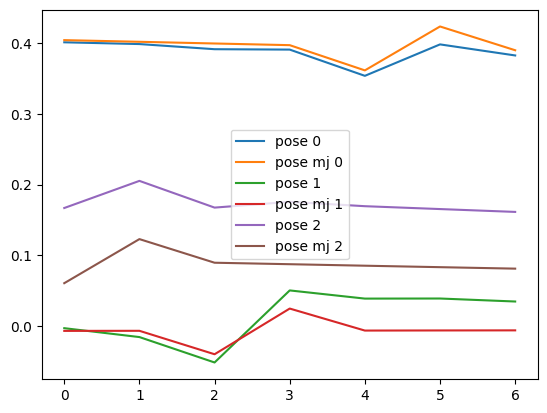

In [12]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.plot(np.array(poses)[:, i], label=f"pose {i}")
    plt.plot(np.array(poses_mj)[:, i], label=f"pose mj {i}")

plt.legend()
plt.show()


(array([ 0.07544936, -0.23749468,  0.20135606, -2.78308487,  0.02191987,
         2.5341392 ,  1.04167361,  0.04      ,  0.04      ]),
 array([-7.8457355e-02,  7.2312690e-02,  7.3141530e-02, -2.7284355e+00,
         3.8262369e-04,  2.7946889e+00,  7.8514880e-01], dtype=float32))